In [1]:
import os
import matplotlib.pyplot as plt
from collections import OrderedDict

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision.datasets import MNIST

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint


if not os.path.exists("data/MNIST"):
    MNIST("data", train=True, download=True)
    MNIST("data", train=False, download=True)

batch_size = 128
num_workers = 8
transform = transforms.Compose([
    transforms.ToTensor()
])
    
mnist_full = MNIST("data", train=True, transform=transform)
train_data, valid_data = random_split(mnist_full, [55000, 5000])
test_data = MNIST("data", train=False, transform=transform)

train_dataloader = DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)
valid_dataloader = DataLoader(valid_data, batch_size=batch_size, num_workers=num_workers)
test_dataloader = DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

In [2]:
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        
        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 256)
        
        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_var = nn.Linear(256, latent_dim)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        
        mu = self.fc_mu(x)
        log_var = self.fc_var(x)
        
        return mu, log_var
    
    
class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        
        self.fc1 = nn.Linear(latent_dim, 256)
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512, 784)
       
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x


class VariationalAutoEncoder(nn.Module):
    def __init__(self, latent_dim=2):
        super().__init__()
        
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)    
    
    
    def reparametrize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        
        return eps * std + mu
        
        
    def forward(self, x, **kwargs):
        mu, log_var = self.encoder(x)
        z = self.reparametrize(mu, log_var)
        
        return self.decoder(z), x, mu, log_var
    
vae = VariationalAutoEncoder(latent_dim=2)
vae

VariationalAutoEncoder(
  (encoder): Encoder(
    (fc1): Linear(in_features=784, out_features=512, bias=True)
    (fc2): Linear(in_features=512, out_features=256, bias=True)
    (fc_mu): Linear(in_features=256, out_features=2, bias=True)
    (fc_var): Linear(in_features=256, out_features=2, bias=True)
  )
  (decoder): Decoder(
    (fc1): Linear(in_features=2, out_features=256, bias=True)
    (fc2): Linear(in_features=256, out_features=512, bias=True)
    (fc3): Linear(in_features=512, out_features=784, bias=True)
  )
)

In [6]:
def vae_loss(recon_image, orig_image, mu, log_var):
    recon_loss = F.mse_loss(recon_image, orig_image, reduction='sum')
    kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim=1), dim=0)
    
    total_loss = recon_loss + 0.1 * kld_loss
    
    return total_loss, recon_loss, kld_loss


class VariationalAE(pl.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model
    
    
    def forward(self, x):
        return self.model(x)
    
    
    def generate(self, x):
        return self.model.decoder(x)
    
    
    def step(self, batch):
        imgs, _ = batch
        imgs = torch.flatten(imgs, start_dim=1)
        recon_image, orig_image, mu, log_var = self(imgs)
        
        total_loss, recon_loss, kld_loss = vae_loss(recon_image, orig_image, mu, log_var)
    
        return total_loss
    
    
    def training_step(self, batch, batch_idx):
        loss = self.step(batch)

        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        
        return loss
    
    
    def validation_step(self, batch, batch_idx):
        loss = self.step(batch)
        
        self.log('valid_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        
        
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=0.001)
        
        return optimizer


callbacks = [
    ModelCheckpoint(monitor='valid_loss', save_top_k=5, dirpath='weights/VAE_MSE', filename='VariationalAE-{epoch:03d}-{valid_loss:.4f}'),
]

    
variational_auto_encoder = VariationalAE(vae)
trainer = pl.Trainer(gpus=[1], max_epochs=50, enable_progress_bar=True, callbacks=callbacks)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [7]:
trainer.fit(variational_auto_encoder, train_dataloader, valid_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type                   | Params
-------------------------------------------------
0 | model | VariationalAutoEncoder | 1.1 M 
-------------------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.275     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

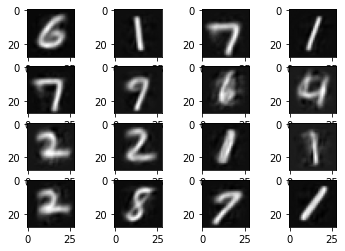

In [8]:
ckpt_fname = "VariationalAE-epoch=048-valid_loss=3513.2649.ckpt"
variational_auto_encoder = variational_auto_encoder.load_from_checkpoint("weights/VAE_MSE/" + ckpt_fname, model=vae)
variational_auto_encoder.model.eval()

try:
    samples = variational_auto_encoder.generate(torch.randn(16, 2).to("cuda:1")).view(-1, 1, 28, 28)
except:
    samples = variational_auto_encoder.generate(torch.randn(16, 2)).view(-1, 1, 28, 28)
samples = samples.detach().moveaxis(1, -1).to("cpu").numpy()

for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(samples[i, :], cmap="gray")

plt.show()